In this homework, you will write a python implementation of a neural network with one hidden layer for the binary classification. Your network takes an n-dimensional data point and produces a scalar z to be used for binary classification.

You will test it on the half moon dataset.

The sections marked **NEW** are the new functions you need to fill in.

First we import some libraries as before.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

We define some functions involved. Use the formulations that avoid overflows.  
1. sigmoid function sigmoid(t)
2. log of sigmoid(t), called log_sig(t)
3. log of 1-sigmoid = 1/(1+e^t), called log_one_sig(t)
4. cross-entropy loss function given the inputs of label y and prediction y_hat = sigmoid(z), where y, y_hat, and z are vectors of dimension N. (N = # of data points.) You should implement this function with z, rather than y_hat, as the input; namely, the loss function should be

    loss = -y log(sigmoid(z)) - (1-y) log (1-sigmoid(z))

  where log(sigmoid(z)) and log (1-sigmoid(z)) should be computed by the functions log_sig(z) and log_one_sig(z) in parts 2 and 3.

In [2]:
def sigmoid(t):
  #print(t, type(t), type(t[0]), len(t))
  return 1.0/(1 + np.exp(-t))

def loss(y, z):
    # compute loss(y, sigmoid(z))
    # y --> label
    # z --> model output

    loss = np.mean(-y*(mylog(z)) - (1-y)*mylogminus(z))
    return loss

def mylog(t):
    # compute log(sigmoid(t)) to be used in loss

    y = 0*t
    m=t.shape[0]
    for i in range(m):
      if t[i] < 0:
        y[i] = t[i]-np.log(1+np.exp(t[i]))
      else:
        y[i] = -np.log(1+np.exp(-t[i]))

    return y

def mylogminus(t):
    # compute log(1-sigmoid(t)) to be used in loss

    y = 0*t
    m=t.shape[0]
    for i in range(m):
      if t[i] < 0:
        y[i] = -np.log(1+np.exp(t[i]))
      else:
        y[i] = -t[i]- np.log(1+np.exp(-t[i]))

    return y


 **New:**
 We define the ReLU function and its derivative ReLUprime

In [3]:
def ReLU(t):
  return np.maximum(0, t)

def ReLUprime(t):
  # derivative of ReLU
  return np.where(t < 0, 0, 1)

**New:** Define the neural network function with one hidden layer. Your function should take the data matrix X (N-by-n matrix) containing N input points and produce a vector of dimension N containing N output values, one for each data point for the binary classification. The function should also take as inputs the model parameters:

output layer: w (n-dimensional weigth vector), b (bias),

hidden layer: W_one (n_one-by-n matrix), and b_one (n_one dimensional vector).

Use ReLU as the nonlinear activation function.

In [4]:
def model(w, b, W_one, b_one, X):

    # X --> N-by-n Input. 500 points x 2 features
    # z --> model output. 500 point vector
    # w --> output layer weight. 150 neuron vector
    # b --> output layer bias. scalar
    # W_one --> hidden layer weight. 150 neurons x 2 features
    # b_one --> hidden layer bias. 150 neurons x 500 points

    # hidden layer
    a_one = np.matmul(W_one, X.T) + b_one[:, np.newaxis] # a_one: 150 neurons x 500 points
    # print("a_one before", a_one)
    a_one = normalize(a_one)
    # print("a_one after", a_one)

    # ^ b_one is added to every column ^
    h_one = ReLU(a_one) # h_one: 150 neurons x 500 points
    # print("h_one before", a_one)
    h_one = normalize(h_one)
    # print("h_one after", a_one)

    # output layer
    z = (np.matmul(w.reshape(1, 150), h_one) + b).flatten().reshape(-1, 1) # z: 500 point vector

    return z, a_one, h_one # N-vector

In [5]:
import math

def normalize(data):
  # data: 2D vector, neurons x points
  (neurons, points) = data.shape
  # normalize point values at each neuron
  for row in data:
    x_bar = np.mean(row)
    v_bar = math.sqrt((1/points)*sum(map(lambda x: (x - x_bar)**2, row)))
    for index, val in np.ndenumerate(row):
      row[index] = (val - x_bar)/v_bar
  return data

**New:** Define the function that generates the output of the neural network and the gradient of the cross-entropy loss using the forward and backward propagation algorithms. The forward propagation should be the same as your *model(w, b, W_one, b_one, X)*.

Your function should take the data matrix X (N-by-n matrix), the label y (N-vector), and the model parameters (w, b, W_one, b_one) as inputs and produces network output z, the gradients dw, db, dW_one, db_one as outputs.

In [6]:
def gradients(w, b, W_one, b_one, X, y):

    # X --> N-by-n Input. 500 x 2
    # z --> model output. 500 x 1
    # w --> output layer weight. 150 x 1
    # b --> output layer bias.
    # W_one --> hidden layer weight. 150 x 2
    # b_one --> hidden layer bias. 150 x 1
    # y --> 500 x 1

    z, a_one, h_one = model(w, b, W_one, b_one, X)
    # a_one: 150 x 500
    # h_one: 150 x 500
    # z: 500 vector

    # dL/dz
    dLdz = sigmoid(z) - y # N-vector. 500 x 1

    # dL/dW
    dw = np.dot(dLdz.T, h_one.T)/len(X) # Should result in a 150x1 vector

    # dL/db
    db = np.sum(dLdz)/len(X) # mean of dLdz

    # dL/dh_one
    dLdz = dLdz.reshape(-1, 1)
    w = w.reshape(1, -1)
    dLdh_one = np.matmul(dLdz, w) # should be 150x500

    # dL/da_one
    a_oneReLUprime = ReLUprime(a_one)
    dLda_one = dLdh_one * a_oneReLUprime.T

    # dL/db_one
    db_one = np.sum(dLda_one, axis=0)

    # dL/dW_one
    dW_one = np.dot(dLda_one.T, X)

    return z, dw.flatten(), db, dW_one, db_one

**New:** Write the function that train the neural network by the gradient descent algorithm using a fixed number of iteration (*iter*) and learning rate (*lr*). Your function should take *iter* and *lr* as well as the initial parameters, the input data X and the label y as the inputs. It produces new parameters as output. Also compute the loss value at each iteration and output the sequence of the loss.

This code should be basically the same as your *train()* function before. The only difference is that you do not need to call the *model()* function, as the model output should have been computed as part of the *gradient()* function output.

In [7]:
def train(w, b, W_one, b_one, X, y, iter, lr):

    # X --> N-by-n Input.
    # z --> model output.
    # w --> output layer weight.
    # b --> output layer bias.
    # W_one --> hidden layer weight.
    # b_one --> hidden layer bias.
    # iter --> number of iterations
    # lr --> Learning rate.

    # N-> number of training examples
    # n-> number of features
    N, n = X.shape

    z, a_one, h_one = model(w, b, W_one, b_one, X)
    y_hat = sigmoid(z)

    # empty list to store losses
    losses = list()

    # training loop
    for i in range(iter):
      z, dw, db, dW_one, db_one = gradients(w, b, W_one, b_one, X, y)
      w -= lr * dw
      b -= lr * db
      W_one -= lr * dW_one
      b_one -= lr * db_one
      l = loss(y, z)
      losses.append(l)
      print('Iteration ', i+1, 'accuracy = ', accuracy(np.squeeze(y),  predict(z)), 'loss = ', l)

    return w, b, W_one, b_one, losses



In [8]:
def mbDivide(X, y, n):
  # X: data
  # y: labels
  # n: number of batches

  numPoints = len(X)

  # to make things a lot easier
  if numPoints % n != 0:
      raise ValueError("The list size is not evenly divisible by n.")

  numPointsPerBatch = int(numPoints / n)

  # randomize indices. result is np.array
  perm = np.random.permutation(numPoints)
  # actually shuffle data and labels. store everything as lists for now
  # I apologize for this disgusting one liner. this just makes lists with the correct length
  dataBatches, labelBatches = list((list((None for j in range(numPointsPerBatch))) for i in range(n))), list((list((None for j in range(numPointsPerBatch))) for i in range(n)))
  listNum = 0
  # indexIndex to see where we are in the dataIndex array. confusing, I know
  for indexIndex, dataIndex in np.ndenumerate(perm):
    if indexIndex[0] % numPointsPerBatch != (numPointsPerBatch - 1):
      dataBatches[listNum][indexIndex[0] % numPointsPerBatch] = X[dataIndex]
      labelBatches[listNum][indexIndex[0] % numPointsPerBatch] = y[dataIndex]
    else:
      dataBatches[listNum][indexIndex[0] % numPointsPerBatch] = X[dataIndex]
      labelBatches[listNum][indexIndex[0] % numPointsPerBatch] = y[dataIndex]
      listNum += 1
  # convert to arrays
  newDataBatches = list((np.array(oldDataBatch) for oldDataBatch in dataBatches))
  newLabelBatches = list((np.array(oldLabelBatch) for oldLabelBatch in labelBatches))

  return newDataBatches, newLabelBatches

In [9]:
def trainMiniBatch(w, b, W_one, b_one, X, y, iter, lr, batchNum):

    # X --> N-by-n Input.
    # z --> model output.
    # w --> output layer weight.
    # b --> output layer bias.
    # W_one --> hidden layer weight.
    # b_one --> hidden layer bias.
    # iter --> number of iterations
    # lr --> Learning rate.
    # batchNum --> Number of batches for minibatch training.

    # N-> number of training examples
    # n-> number of features
    N, n = X.shape

    # empty list to store losses
    losses = list()

    # training loop
    for i in range(iter):
      # divide data
      dataList, labelList = mbDivide(X, y, batchNum)

      # proceed as normal
      for j in range(batchNum):
        z, a_one, h_one = model(w, b, W_one, b_one, dataList[j])
        y_hat = sigmoid(z)
        z, dw, db, dW_one, db_one = gradients(w, b, W_one, b_one, dataList[j], labelList[j])
        w -= lr * dw
        b -= lr * db
        W_one -= lr * dW_one
        b_one -= lr * db_one
        l = loss(labelList[j], z)
        losses.append(l)
        print('Iteration', i+1, "batch", j+1, 'accuracy = ', accuracy(np.squeeze(labelList[j]),  predict(z)), 'loss = ', l)

    return w, b, W_one, b_one, losses


As before,

1. *predict()* produces class prediction label y_label (N-vector of 0 or 1) given the model output z.

2. *accuracy()* computes the accuracy of prediction.



In [10]:
def predict(output):

    # output --> model output
    # pred_class --> model class prediction

    # Empty List to store predictions.
    pred_class = []
    # if z >= 0 --> 1
    # if z < 0 --> 0
    pred_class = [1 if i > 0 else 0 for i in output]

    return np.array(pred_class)

def accuracy(y, y_predict):
    accuracy = np.sum(y == y_predict) / len(y)
    return accuracy


**New:** We test the code on the half moon dataset. The code below  uses l_one = 150 neurons in the hidden layer and the weights are initialized to be the stadard random normal distribution N(0,1). You should also try the Xavier Glorot and Kaiming He initializations. You should try at least 4 learning rates. Your best accuracy should well exceed 95% with a loss below 0.1.

In [11]:
url = 'https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv'
data = pd.read_csv(url)

cat_vars=['default','education','contact','month','day_of_week',]
data=data.drop(cat_vars, axis=1)
print(list(data.columns))
print(data.shape)
cat_vars=['job','marital','housing','loan','poutcome']
for va in cat_vars:
    #cat_pre='var'+'_'+var
    print(va)
    #print(data[va])
    cat_list = pd.get_dummies(data[va])
    data1=pd.concat([data,cat_list], axis=1)
    data=data1.drop(va, axis=1)
    #print(list(cat_list.columns))
    #print(list(data.columns))
    #print(data.shape)

X = data.loc[:, data.columns != 'y']
y = data.loc[:, data.columns == 'y']
columns = X.columns
X=X.to_numpy().astype(np.float64)
y=y.to_numpy().astype(np.float64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

['age', 'job', 'marital', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']
(41188, 16)
job
marital
housing
loan
poutcome


Iteration 1 batch 1 accuracy =  0.41816100724914157 loss =  7.1594098121079615
Iteration 1 batch 2 accuracy =  0.6608164822586798 loss =  10.532760828807668
Iteration 1 batch 3 accuracy =  0.7203357497138497 loss =  31.304228990182608
Iteration 1 batch 4 accuracy =  0.7191911484166349 loss =  32.172659204282034
Iteration 1 batch 5 accuracy =  0.7035482640213659 loss =  29.915983013101574
Iteration 1 batch 6 accuracy =  0.7073636016787486 loss =  25.763284162394662
Iteration 1 batch 7 accuracy =  0.7096528042731782 loss =  25.08838193492023
Iteration 1 batch 8 accuracy =  0.7054559328500573 loss =  25.111553076498122
Iteration 1 batch 9 accuracy =  0.7069820679130103 loss =  24.15984897926366
Iteration 1 batch 10 accuracy =  0.6898130484547883 loss =  24.392790968199915
Iteration 1 batch 11 accuracy =  0.7066005341472721 loss =  21.627833173056864
Iteration 2 batch 1 accuracy =  0.7069820679130103 loss =  22.348633401560843
Iteration 2 batch 2 accuracy =  0.710797405570393 loss =  20.80

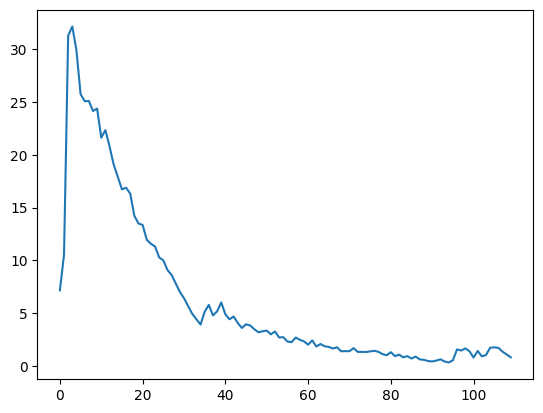

In [12]:
"""from sklearn.datasets import make_moons
X_train, y_train = make_moons(n_samples=500, noise=0.1)
X_test, y_test = make_moons(n_samples=1000, noise=0.1)"""

#plt.figure()
#plt.plot(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], "g^")
#plt.plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bs")

# initialization
l_one=150
n=X_train.shape[1]
w=np.random.randn(l_one)
b = 0
W_one = np.random.randn(l_one, X_train.shape[1])
b_one = 0*np.random.rand(l_one)

# train
w, b, W_one, b_one, losses = trainMiniBatch(w, b, W_one, b_one, X_train, y_train, iter=10, lr=0.1, batchNum=11)

# print results
plt.figure()
plt.plot(losses)

#training accuracy
z = model(w,b,W_one, b_one,X_train)[0]
acc = accuracy(np.squeeze(y_train), predict(np.squeeze(z)))
print(acc)

# testing accuracy
z = model(w,b,W_one, b_one,X_test)[0]
acc = accuracy(np.squeeze(y_test), predict(np.squeeze(z)))

print(acc)

NOW FOR KERAS

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [14]:
import pandas as pd
url = 'https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv'
data = pd.read_csv(url)

In [15]:
cat_vars=['default','education','contact','month','day_of_week',]
data=data.drop(cat_vars, axis=1)
print(list(data.columns))
print(data.shape)
cat_vars=['job','marital','housing','loan','poutcome']
for va in cat_vars:
    #cat_pre='var'+'_'+var
    print(va)
    #print(data[va])
    cat_list = pd.get_dummies(data[va])
    data1=pd.concat([data,cat_list], axis=1)
    data=data1.drop(va, axis=1)
    #print(list(cat_list.columns))
    #print(list(data.columns))
    #print(data.shape)

print(data.shape)
print(list(data.columns))

['age', 'job', 'marital', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']
(41188, 16)
job
marital
housing
loan
poutcome
(41188, 36)
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y', 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown', 'divorced', 'married', 'single', 'unknown', 'no', 'unknown', 'yes', 'no', 'unknown', 'yes', 'failure', 'nonexistent', 'success']


In [16]:
X = data.loc[:, data.columns != 'y']
y = data.loc[:, data.columns == 'y']
columns = X.columns
X=X.to_numpy()
y=y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(columns)

(28831, 35)
(12357, 35)
Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'admin.',
       'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired',
       'self-employed', 'services', 'student', 'technician', 'unemployed',
       'unknown', 'divorced', 'married', 'single', 'unknown', 'no', 'unknown',
       'yes', 'no', 'unknown', 'yes', 'failure', 'nonexistent', 'success'],
      dtype='object')


In [17]:
# Model / data parameters
num_classes = 2
input_shape = (1, 35)

# Scale images to the [0, 1] range
scaler = MinMaxScaler(feature_range=(0, 1))
scaledX_train = scaler.fit_transform(X_train)
scaledX_test = scaler.fit_transform(X_test)

In [18]:
initializer = tf.keras.initializers.GlorotUniform
#regularizer=tf.keras.regularizers.L2(0.0001)
model = tf.keras.models.Sequential([
    # tf.keras.layers.Flatten(), # converts 28x28 image to a 784 vector
    tf.keras.layers.Dense(128, activation=tf.nn.relu,
                          kernel_initializer=initializer),
    # You may add a dropout to this layer by adding a dropout layer as below
    # tf.keras.layers.Dropout(.2, input_shape=(2,)),
    tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_initializer=initializer),
    tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_initializer=initializer),
    tf.keras.layers.Dense(1, activation=None, kernel_initializer=initializer)
    # This output is z without softmax. It's called logits.
    # you could also use an output layer with softmax activation as in below
    # In that case, your definition of loss will include from_logits=False
    # tf.keras.layers.Dense(10, activation='softmax', kernel_initializer=initializer)
])

In [19]:
def convertToArray(oldList):
  newList = list()
  counter = 0
  while counter < len(oldList):
    newList.append(oldList[counter][0])
    counter += 1
  return np.array(newList).reshape(-1, 1)

In [20]:
y_train = convertToArray(y_train)
y_test = convertToArray(y_test)

Epoch 1/40
203/203 [==============================] - 2s 4ms/step - loss: 0.3289 - accuracy: 0.8943 - val_loss: 0.2268 - val_accuracy: 0.8929
Epoch 2/40
203/203 [==============================] - 1s 3ms/step - loss: 0.2157 - accuracy: 0.8949 - val_loss: 0.2538 - val_accuracy: 0.8852
Epoch 3/40
203/203 [==============================] - 1s 3ms/step - loss: 0.2115 - accuracy: 0.8979 - val_loss: 0.2311 - val_accuracy: 0.8790
Epoch 4/40
203/203 [==============================] - 1s 3ms/step - loss: 0.2140 - accuracy: 0.8971 - val_loss: 0.2228 - val_accuracy: 0.9015
Epoch 5/40
203/203 [==============================] - 1s 3ms/step - loss: 0.2124 - accuracy: 0.8958 - val_loss: 0.2206 - val_accuracy: 0.8939
Epoch 6/40
203/203 [==============================] - 1s 3ms/step - loss: 0.2089 - accuracy: 0.8914 - val_loss: 0.2213 - val_accuracy: 0.9036
Epoch 7/40
203/203 [==============================] - 1s 5ms/step - loss: 0.2132 - accuracy: 0.8977 - val_loss: 0.2231 - val_accuracy: 0.8915
Epoch 

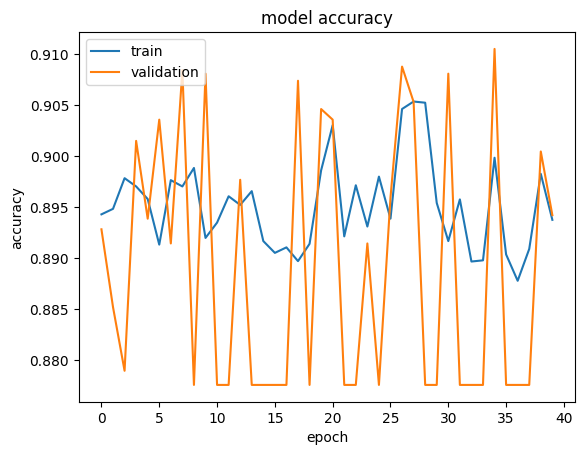

In [21]:
batch_size = 128
epochs = 40
# opt=keras.optimizers.SGD(learning_rate=0.1)
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(
    optimizer=opt,
    loss=loss,
    metrics=["accuracy"],
)
X_train_tensor = tf.convert_to_tensor(scaledX_train, dtype=tf.float32)
history=model.fit(X_train_tensor, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
# Evaluate on test data
X_test_tensor = tf.convert_to_tensor(scaledX_test, dtype=tf.float32)
test_loss, test_accuracy = model.evaluate(scaledX_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

387/387 [==============================] - 1s 2ms/step - loss: 0.2161 - accuracy: 0.9050
Test Accuracy: 90.50%
